# **1. Installation des librairies**

In [7]:
!pip install captum
!pip install pytorch_lightning

  Using cached pytorch_lightning-2.5.5-py3-none-any.whl.metadata (20 kB)
  Using cached torchmetrics-1.8.2-py3-none-any.whl.metadata (22 kB)
  Using cached lightning_utilities-0.15.2-py3-none-any.whl.metadata (5.7 kB)
Using cached pytorch_lightning-2.5.5-py3-none-any.whl (832 kB)
Using cached lightning_utilities-0.15.2-py3-none-any.whl (29 kB)
Using cached torchmetrics-1.8.2-py3-none-any.whl (983 kB)


# **2. Téléchargement du jeu de données de test**

In [3]:
!wget https://nextcloud.ig.umons.ac.be/s/GTf7wcpCFraPzxB/download/test.zip
!unzip test.zip -d test
!rm test.zip

--2025-10-21 15:40:34--  https://nextcloud.ig.umons.ac.be/s/GTf7wcpCFraPzxB/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://nextcloud.ig.umons.ac.be/public.php/dav/files/GTf7wcpCFraPzxB/?accept=zip [following]
--2025-10-21 15:40:35--  https://nextcloud.ig.umons.ac.be/public.php/dav/files/GTf7wcpCFraPzxB/?accept=zip
Reusing existing connection to nextcloud.ig.umons.ac.be:443.
HTTP request sent, awaiting response... 200 OK
Length: 49569242 (47M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  47.27M  9.15MB/s    in 5.7s    

2025-10-21 15:40:41 (8.25 MB/s) - ‘test.zip’ saved [49569242/49569242]

Archive:  test.zip
   creating: test/test/
   creating: test/test/fire/
  inflating: test/test/fire/F_1000.jpg  
  inflating: test/tes

# **3. Importation des librarires**

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms
import torch.nn as nn
from captum.attr import LayerGradCam
import matplotlib.pyplot as plt
from torchvision import models
import pytorch_lightning as pl
import numpy as np
import cv2

ImportError: cannot import name 'broadcast_to' from 'numpy.lib.stride_tricks' (/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/numpy/lib/stride_tricks.py)

# **4. Chargement des données : test_loader**

In [ ]:
# @title
img_size = 224
testset_path  = "/test/test/"
batch_size = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

img_size = 224
folder_path  = 'test_data/TestData'
model = torch.jit.load(os.path.join(os.getcwd(), "checkpoints/best_vgg_DB2_model_jit.pth"))

test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

test_dataset = datasets.ImageFolder(testset_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# **5. Chargement du modèle**

In [ ]:
 #useless because load with .pth model which contain model strucutre + weight in comparaison to .ckpt that just has the weights

# class FireDetectionModel(pl.LightningModule):
#     def __init__(self, num_classes=3, learning_rate=3e-4):
#         super().__init__()
#         self.model = models.efficientnet_v2_s(weights="DEFAULT")
#         self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
#         self.criterion = nn.CrossEntropyLoss()
#         self.learning_rate = learning_rate

#     def forward(self, x):
#         return self.model(x)

# model = FireDetectionModel.load_from_checkpoint("testmodel-sidi.ckpt")
# model.eval()


FireDetectionModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNo

# **6. Application de la méthode XAI "GradCAM" sur la première image**

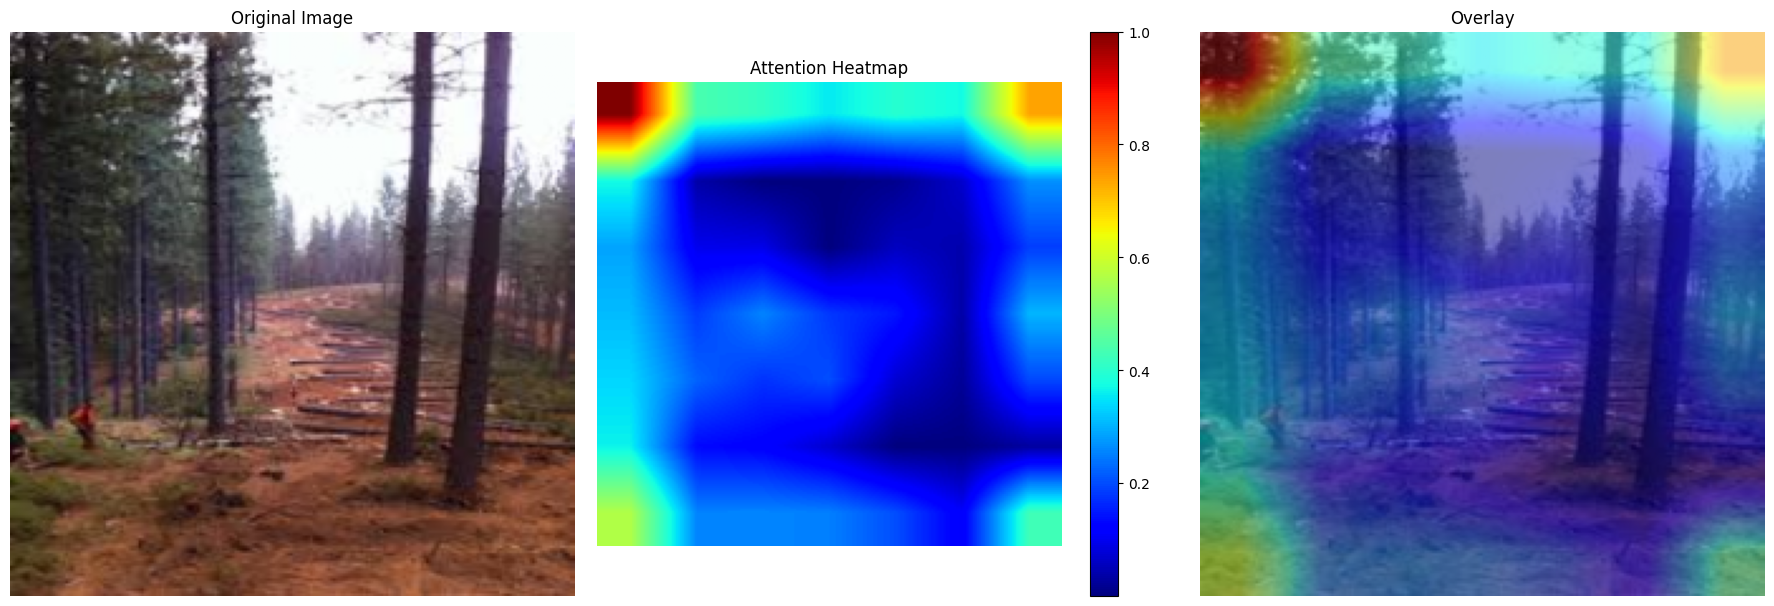

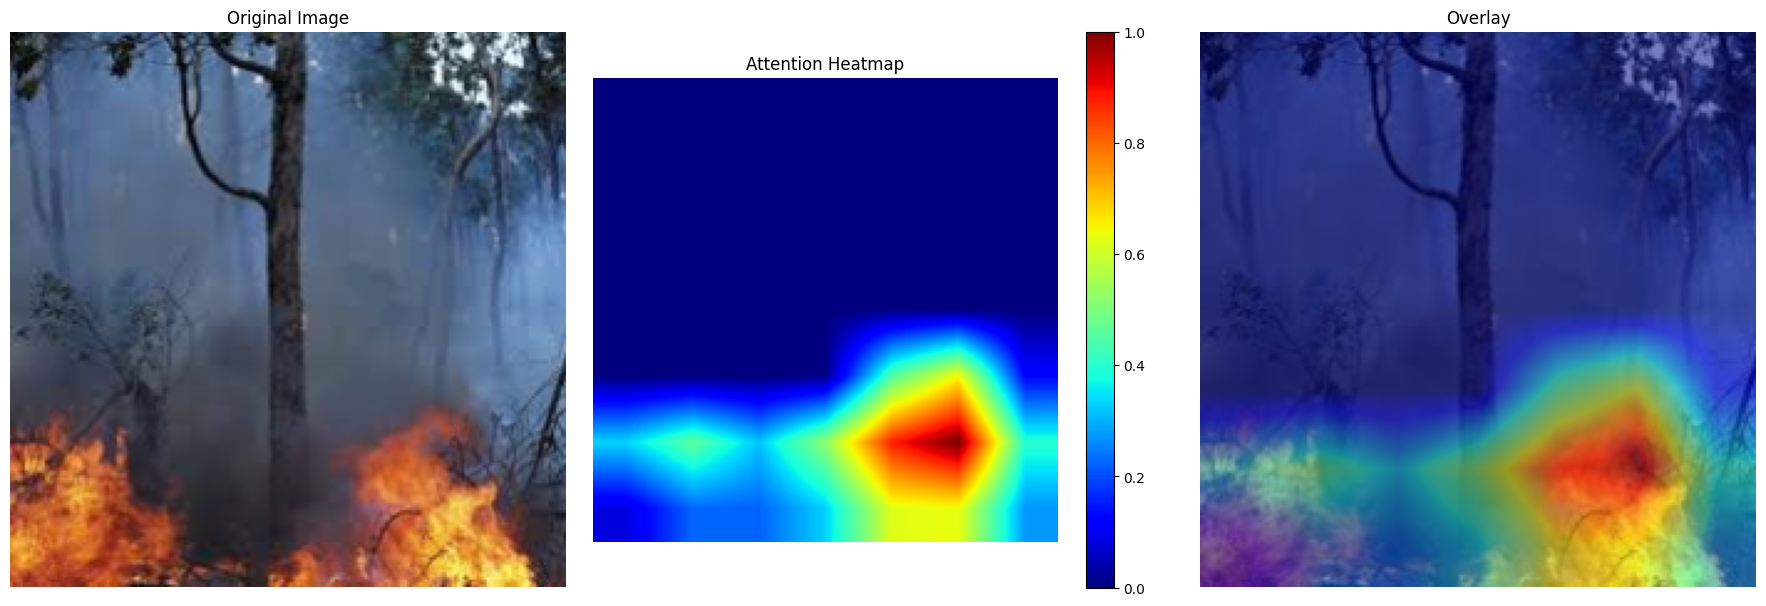

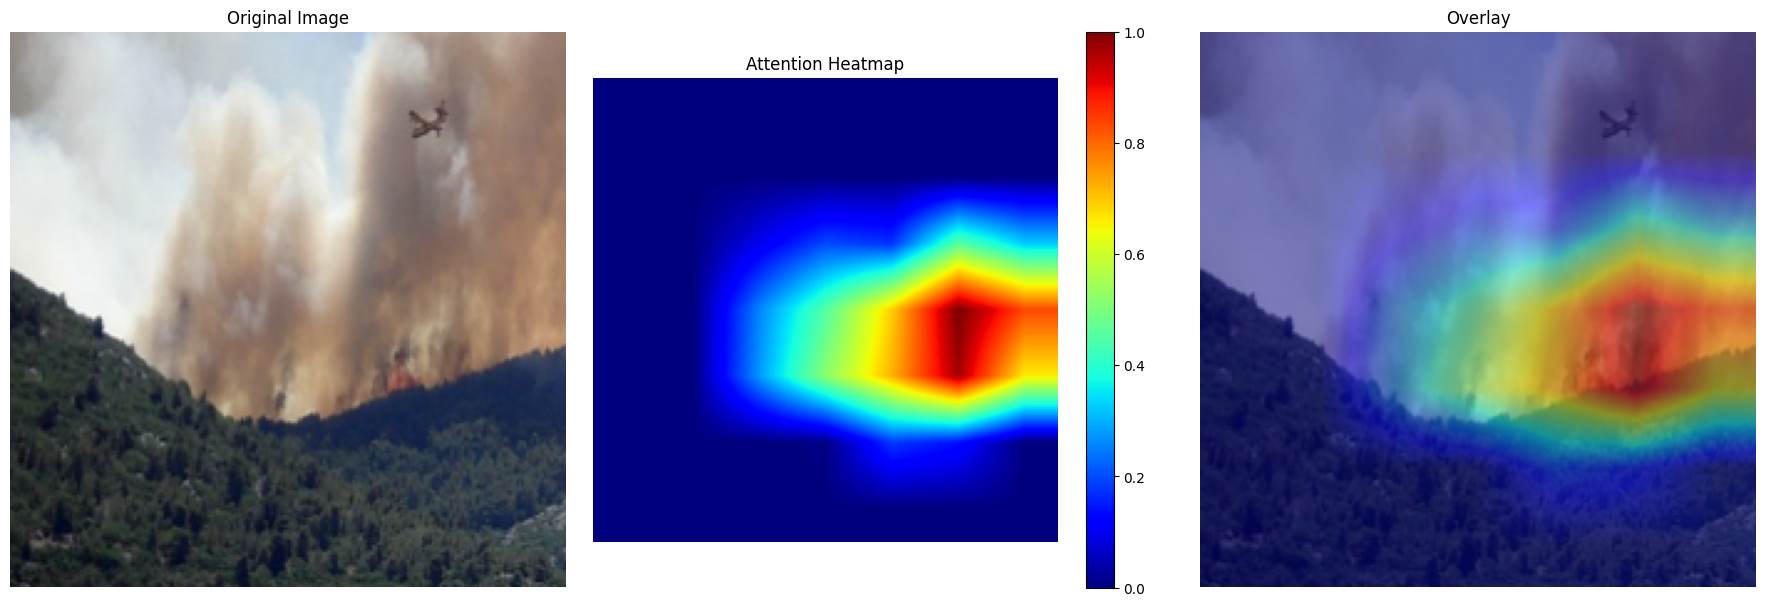

In [53]:
def get_last_conv_layer(model):
    last_conv_layer = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            last_conv_layer = module
    if last_conv_layer is None:
        raise ValueError("No Conv2d layer found in the model.")
    return last_conv_layer

def visualize_gradcam(model, inputs, labels, device, figsize=(18, 6)):
    # Get last convolutional layer
    last_conv_layer = get_last_conv_layer(model)
    gradcam = LayerGradCam(model, last_conv_layer)

    # Convert labels if necessary
    if isinstance(labels, torch.Tensor):
        labels = int(torch.argmax(labels.detach()).cpu().numpy())

    # Compute Grad-CAM attribution
    attribution = gradcam.attribute(inputs, target=labels, relu_attributions=True)

    # Convert tensors to numpy arrays
    attribution_np = attribution[0].cpu().detach().numpy()
    inputs_np = inputs[0].cpu().permute(1, 2, 0).detach().numpy()

    # Get original image dimensions
    height, width = inputs_np.shape[:2]

    # Resize attribution map to match input image size
    heatmap = cv2.resize(attribution_np[0], (width, height))

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Original image
    axes[0].imshow(inputs_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Heatmap only
    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Attention Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])

    # Overlay
    axes[2].imshow(inputs_np)
    axes[2].imshow(heatmap, alpha=0.5, cmap='jet')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    return fig

test_iter = iter(test_loader)

# Premier batch
inputs1, labels1 = next(test_iter)
inputs1 = inputs1.to(device)

# Deuxième batch
inputs2, labels2 = next(test_iter)
inputs2 = inputs2.to(device)

# Troisième batch
inputs3, labels3 = next(test_iter)
inputs3 = inputs3.to(device)

fig = visualize_gradcam(model, inputs1, labels1, device)

fig = visualize_gradcam(model, inputs2, labels2, device)

fig = visualize_gradcam(model, inputs3, labels3, device)
plt.show()